# 時系列データの特徴量の算出

## データの読み込みと可視化

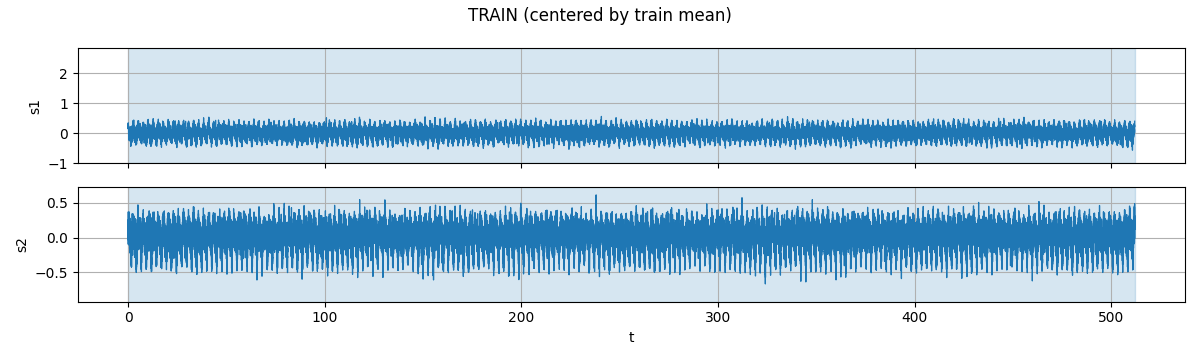

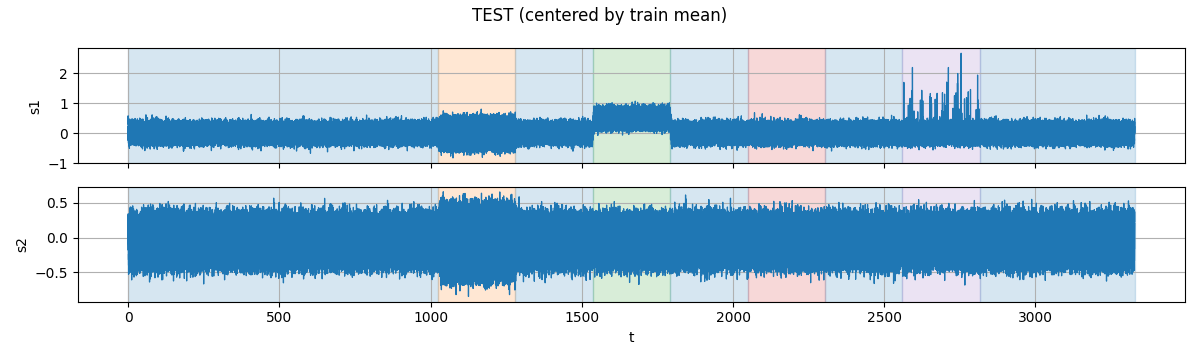

In [1]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ============================================================
# 設定（ここだけ）
# ============================================================
TRAIN_CSV = r"data_train_Smooth.csv"
TEST_CSV  = r"data_test_Smooth.csv"

# 指定しなければ（Noneなら）：
# TIME_COL  -> 行番号を時刻扱い
# LABEL_COL -> ラベル無し（背景塗り無し）
TIME_COL  = "t"      # 例: "t"
LABEL_COL = "label"  # 例: "label"

VALUE_COLS = ["s1","s2"]  # 必ず指定


# ============================================================
# CSV読み込み（落ちにくく）
# ============================================================
def read_csv_robust(path: str) -> pd.DataFrame:
    last_err = None
    for enc in ("utf-8-sig", "utf-8", "cp932", "shift_jis"):
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception as e:
            last_err = e
    try:
        return pd.read_csv(path, encoding_errors="replace")
    except Exception as e:
        raise RuntimeError(f"CSVが読み込めませんでした: {path}\n最後のエラー: {last_err}\n最終試行エラー: {e}")


# ============================================================
# センタ（学習平均との差し引きを学習・テストに適用）
# ============================================================
def center_by_train_mean(df_tr: pd.DataFrame, df_te: pd.DataFrame, cols: list[str]) -> tuple[pd.DataFrame, pd.DataFrame]:
    base = df_tr[cols].mean(axis=0, skipna=True)
    tr_c = df_tr.copy()
    te_c = df_te.copy()
    tr_c[cols] = tr_c[cols] - base
    te_c[cols] = te_c[cols] - base
    return tr_c, te_c


# ============================================================
# ラベル区間（ラベルが変わるたびに区間分割）
# ============================================================
def label_segments(x: np.ndarray, labels: np.ndarray):
    if labels.size == 0:
        return []

    lab = labels.astype(object)
    for i in range(lab.size):
        if pd.isna(lab[i]):
            lab[i] = "NaN"

    segs = []
    start_i = 0
    for i in range(1, lab.size):
        if lab[i] != lab[i - 1]:
            segs.append((x[start_i], x[i - 1], lab[i - 1]))
            start_i = i
    segs.append((x[start_i], x[-1], lab[-1]))
    return segs


# ============================================================
# 学習・テストで共通のylim（列ごと）
# ============================================================
def compute_ylims(df_a: pd.DataFrame, df_b: pd.DataFrame, cols: list[str]) -> dict[str, tuple[float, float]]:
    ylims = {}
    for c in cols:
        ya = pd.to_numeric(df_a[c], errors="coerce").to_numpy(dtype=float)
        yb = pd.to_numeric(df_b[c], errors="coerce").to_numpy(dtype=float)
        y = np.concatenate([ya, yb])
        y = y[np.isfinite(y)]
        if y.size == 0:
            ylims[c] = (-1.0, 1.0)
            continue
        lo, hi = float(np.min(y)), float(np.max(y))
        if lo == hi:
            lo -= 1.0
            hi += 1.0
        pad = 0.05 * (hi - lo)
        ylims[c] = (lo - pad, hi + pad)
    return ylims


# ============================================================
# タイル（縦並び）プロット：背景ラベル塗り
# ============================================================
def plot_tiled_timeseries(
    df: pd.DataFrame,
    time_col: str | None,
    value_cols: list[str],
    label_col: str | None,
    title: str,
    ylims_by_col: dict[str, tuple[float, float]],
):
    if time_col is None:
        x = np.arange(len(df), dtype=float)
        x_label = "index"
    else:
        x = pd.to_numeric(df[time_col], errors="coerce").to_numpy(dtype=float)
        if np.isnan(x).all():
            x = np.arange(len(df), dtype=float)
            x_label = "index"
        else:
            x_label = time_col

    segs = []
    label_to_color = {}
    if label_col is not None and label_col in df.columns:
        labs = df[label_col].to_numpy()
        segs = label_segments(x, labs)

        uniq = []
        for _, _, lb in segs:
            if lb not in uniq:
                uniq.append(lb)

        cmap = plt.get_cmap("tab10")
        for i, lb in enumerate(uniq):
            label_to_color[lb] = cmap(i % 10)

    n = len(value_cols)
    fig, axes = plt.subplots(n, 1, sharex=True, figsize=(12, max(3.2, 1.8 * n)))
    if n == 1:
        axes = [axes]

    for ax, col in zip(axes, value_cols):
        y = pd.to_numeric(df[col], errors="coerce").to_numpy(dtype=float)

        if segs:
            for xs, xe, lb in segs:
                ax.axvspan(xs, xe, alpha=0.18, color=label_to_color.get(lb, None))

        ax.plot(x, y, linewidth=0.9)
        ax.set_ylabel(col)
        ax.set_ylim(*ylims_by_col[col])
        ax.grid(True)

    axes[-1].set_xlabel(x_label)
    fig.suptitle(title)
    fig.tight_layout()
    plt.show()


# ============================================================
# 実行部（上から順に流す）
# ============================================================
# 前提：
# - LABEL_COL は必ず存在する（Noneではない、列もある）
# - TIME_COL は None なら行番号、指定するなら列がある
# - VALUE_COLS は必ず列として存在する

df_tr = read_csv_robust(TRAIN_CSV)
df_te = read_csv_robust(TEST_CSV)

df_tr_c, df_te_c = center_by_train_mean(df_tr, df_te, VALUE_COLS)
ylims = compute_ylims(df_tr_c, df_te_c, VALUE_COLS)

plot_tiled_timeseries(
    df_tr_c,
    time_col=TIME_COL,
    value_cols=VALUE_COLS,
    label_col=LABEL_COL,
    title="TRAIN (centered by train mean)",
    ylims_by_col=ylims,
)

plot_tiled_timeseries(
    df_te_c,
    time_col=TIME_COL,
    value_cols=VALUE_COLS,
    label_col=LABEL_COL,
    title="TEST (centered by train mean)",
    ylims_by_col=ylims,
)


## 周期性の確認

In [2]:
import numpy as np
import pandas as pd
from scipy import signal
from statsmodels.tsa.stattools import acf as sm_acf


def periodicity_scores_with_curves(x, lag_min=20, lag_max=2000, top_k=5, psd_nperseg=2048):
    """
    time_col無し前提で統一（fs=1.0）
    - ACF/PSDの曲線を1回だけ計算
    - その曲線からピーク候補dfを作成
    戻り: (df_scores, ac, lags, f, Pxx, mask)
    """
    fs = 1.0

    x = np.asarray(x, dtype=float).ravel()
    if np.any(~np.isfinite(x)):
        med = np.nanmedian(x)
        x = np.where(np.isfinite(x), x, med)

    # 平均引きはここで1回だけ
    x = signal.detrend(x, type="constant")

    n = x.size
    lag_max = int(min(lag_max, n - 2))
    lag_min = int(max(1, lag_min))
    if lag_max <= lag_min:
        raise ValueError("lag範囲が不正です（データ長 or lag_min/lag_max を見直し）")

    # --- 曲線（1回だけ計算） ---
    ac = sm_acf(x, nlags=lag_max, fft=True, missing="drop")
    lags = np.arange(ac.size, dtype=float)

    # welchは detrend=False にして二重平均引きを避ける（上で引いたため）
    f, Pxx = signal.welch(
        x, fs=fs, window="hann", nperseg=psd_nperseg, detrend=False, scaling="density"
    )

    fmin = max(1e-12, fs / lag_max)         # = 1/lag_max
    fmax = min(0.5 * fs, fs / lag_min)      # = min(0.5, 1/lag_min)
    m = (f >= fmin) & (f <= fmax) & np.isfinite(Pxx)

    # --- 曲線からピーク候補を抽出 ---
    def _top_peaks(y, axis, method, axis_kind):
        y = np.asarray(y, dtype=float)
        axis = np.asarray(axis, dtype=float)
        if y.size == 0:
            return pd.DataFrame()

        peaks, _ = signal.find_peaks(y)  # しきい値なし
        if peaks.size == 0:
            return pd.DataFrame()

        prom = signal.peak_prominences(y, peaks)[0].astype(float)
        wid = signal.peak_widths(y, peaks, rel_height=0.5)[0].astype(float)

        order = np.argsort(prom)[::-1][:top_k]
        rows = []

        if axis_kind == "freq":
            d_axis = float(np.median(np.diff(axis))) if axis.size >= 2 else np.nan

        for rk, i in enumerate(order, start=1):
            p = int(peaks[i])
            ax = float(axis[p])

            if axis_kind == "lag":
                T = int(round(ax))
                rows.append({
                    "method": method,
                    "rank": rk,
                    "period_samples": T,
                    "freq_hz": float(1.0 / T) if T > 0 else np.nan,  # cycles/sample
                    "peak": float(y[p]),
                    "prominence": float(prom[i]),
                    "width": float(wid[i]),
                    "width_unit": "samples",
                })
            else:
                f0 = ax  # cycles/sample
                rows.append({
                    "method": method,
                    "rank": rk,
                    "period_samples": float(1.0 / (f0 + 1e-12)),
                    "freq_hz": float(f0),
                    "peak": float(y[p]),
                    "prominence": float(prom[i]),
                    "width": float(wid[i] * d_axis) if np.isfinite(d_axis) else np.nan,
                    "width_unit": "cycles/sample",
                })
        return pd.DataFrame(rows)

    df_acf = _top_peaks(
        y=ac[lag_min:lag_max + 1],
        axis=lags[lag_min:lag_max + 1],
        method="acf",
        axis_kind="lag",
    )
    df_psd = _top_peaks(
        y=Pxx[m],
        axis=f[m],
        method="psd_welch",
        axis_kind="freq",
    )

    df_scores = pd.concat([df_acf, df_psd], ignore_index=True).sort_values(["method", "rank"]).reset_index(drop=True)
    return df_scores, ac, lags, f, Pxx, m, lag_min, lag_max




,method,rank,period_samples,freq_hz,peak,prominence,width,width_unit
0,acf,1,255.000000,0.003922,0.640253,1.004710,78.713746,samples
1,acf,2,514.000000,0.001946,0.637305,1.001113,78.744013,samples
2,acf,3,768.000000,0.001302,0.637530,0.999183,78.342056,samples
3,acf,4,1025.000000,0.000976,0.630848,0.989927,78.573367,samples
4,acf,5,1280.000000,0.000781,0.627929,0.985312,78.744104,samples
5,psd_welch,1,256.000000,0.003906,16.385931,16.368220,0.000652,cycles/sample
6,psd_welch,2,128.000000,0.007812,5.362226,5.344096,0.000654,cycles/sample
7,psd_welch,3,85.333333,0.011719,2.255358,2.240141,0.000656,cycles/sample
8,psd_welch,4,51.200000,0.019531,0.808638,0.792369,0.000665,cycles/sample
9,psd_welch,5,30.567164,0.032715,0.029396,0.015160,0.001443,cycles/sample


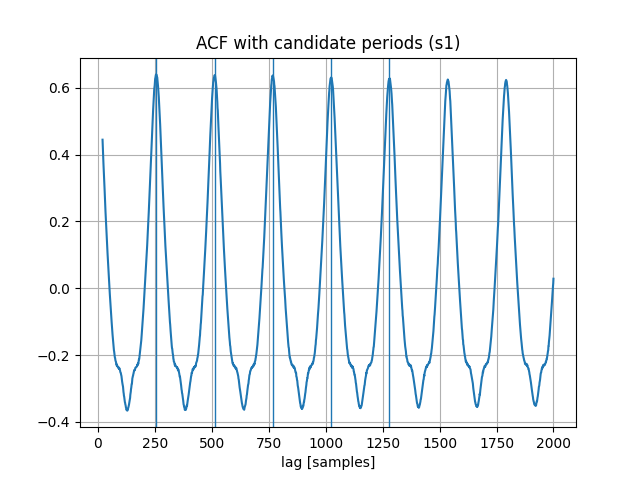

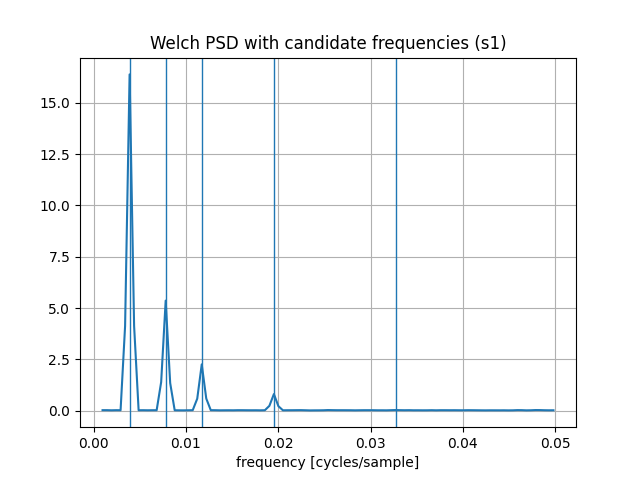

In [3]:
# ------------------------------------------------------------
# 実行（代表センサを選んで周期候補を出す）
# ------------------------------------------------------------
SENSOR_FOR_PERIOD = VALUE_COLS[0]
x = pd.to_numeric(df_tr_c[SENSOR_FOR_PERIOD], errors="coerce").to_numpy(dtype=float)

df_scores, ac, lags, f, Pxx, m, lag_min, lag_max = periodicity_scores_with_curves(
    x,
    lag_min=20,        # 探索する「最小周期」[samples]
                      # - time_col無し前提なので 1サンプル=1単位
                      # - これより短い周期（高周波）は候補から除外
                      # - 例：最短で20サンプル周期以上を見たい → lag_min=20

    lag_max=2000,      # 探索する「最大周期」[samples]
                      # - これより長い周期（低周波）は候補から除外
                      # - 例：最大で2000サンプル周期まで探す → lag_max=2000
                      # - 注意：データ長が短いと自動で n-2 に丸められる

    top_k=5,           # 各手法（ACF / PSD）で上位いくつの候補を返すか
                      # - prominence（目立ち度）が大きい順に top_k 個
                      # - 例：上位5候補だけ見たい → top_k=5

    psd_nperseg=2048,  # Welch PSD の 1区間の長さ（FFTをかける窓長）[samples]
                      # - 大きいほど周波数分解能が上がり、ピーク周波数が細かく分かる
                      # - ただし平均に使う区間数が減り、ノイズでPSDが揺れやすくなる
                      # - 小さいほど分解能は落ちるが、平均回数が増えて滑らかになりやすい
                      # - 一般に「lag_max と同程度〜数倍」か「データ長の1/4程度」から試す
                      # - SciPy welch は nperseg > len(x) のとき自動で len(x) に丸める
)

display(df_scores)

# ------------------------------------------------------------
# 可視化：ACF（候補周期に縦線）
# ------------------------------------------------------------
T_list = df_scores.loc[df_scores["method"] == "acf", "period_samples"].dropna().tolist()

plt.figure()
plt.plot(lags[lag_min:lag_max + 1], ac[lag_min:lag_max + 1])
for T in T_list:
    plt.axvline(float(T), linewidth=1)
plt.xlabel("lag [samples]")
plt.title(f"ACF with candidate periods ({SENSOR_FOR_PERIOD})")
plt.grid(True)
plt.show()

# ------------------------------------------------------------
# 可視化：Welch PSD（候補周波数に縦線）
# ------------------------------------------------------------
f_list = df_scores.loc[df_scores["method"] == "psd_welch", "freq_hz"].dropna().tolist()

plt.figure()
plt.plot(f[m], Pxx[m])
for f0 in f_list:
    plt.axvline(float(f0), linewidth=1)
plt.xlabel("frequency [cycles/sample]")
plt.title(f"Welch PSD with candidate frequencies ({SENSOR_FOR_PERIOD})")
plt.grid(True)


## この図は何か（Welch PSD）

この図は「周波数ごとの強さ（エネルギー）」を並べたものです。

- 横軸：frequency [cycles/sample]
  - time_col を使わない前提なので **cycles/sample（1サンプルあたり何回繰り返すか）**
- 縦軸：PSD（その周波数成分の強さ）
  - 値が大きいほど、その周波数の繰り返し成分が強い

曲線の**山（ピーク）**が「周期性が強い周波数」です。

---

## 「周波数」から「周期（サンプル数）」への変換

横軸が cycles/sample のとき、周期（何サンプルで1回繰り返すか）は

$$
\text{period\_samples} \approx \frac{1}{f}
$$

例：
- f = 0.01 cycles/sample → period ≈ 1/0.01 = 100 samples
- f = 0.003 cycles/sample → period ≈ 333 samples

---

## 青い縦線は何か

青い縦線は、`df_scores` の `method == "psd_welch"` が選んだ
「候補周波数（上位 top_k）」の位置です。

- 曲線（PSD）：周波数ごとの強さ
- 縦線：候補（この周波数が周期っぽい）

**縦線がPSDのピーク頂上付近に刺さっていれば、その候補は妥当**です。

---

## なぜピークが複数あるのか（基本周波数と高調波）

ピークが複数出るのは普通です。

波形が「きれいな正弦波」ではなく、
尖り・段差・歪みがあると、次が同時に出ます。

- 基本周波数：いちばんゆっくりした“本体の繰り返し”
- 高調波：基本周波数の 2倍、3倍… の成分

そのため
「一番高いピーク = 本当の周期」とは限りません。

例：
- 本当の基本周波数が f0 = 0.005（周期200）
- 2倍の 0.01（周期100）が強く見えることもある

---


## データを窓ごとに整理

In [4]:
import numpy as np
import pandas as pd


# ============================================================
# 1) 連続データ(df)を「1行=1窓」に変換（窓は全センサで同じ切り方）
# ============================================================
def make_window_starts(n, win, step):
    """
    n: 全長（サンプル数）
    win: 窓長（サンプル数）
    step: ステップ（サンプル数）
    戻り: starts（各窓の開始インデックス配列）
    """
    if win <= 0 or step <= 0:
        raise ValueError("win, step は正の整数にしてください")
    if n < win:
        return np.array([], dtype=int)
    return np.arange(0, n - win + 1, step, dtype=int)


def windowize_df(
    df: pd.DataFrame,
    sensor_cols: list[str],
    win: int,
    step: int,
    time_col: str | None = None,
    label_col: str | None = None,
    label_rule: str = "center",   # "center" / "majority"
):
    """
    目的：
      - df（時刻, センサ列..., ラベル列...）から、センサごとに
        X[sensor] = shape(n_win, win) の「1行=1窓」行列を作る
      - 併せて、各窓の開始/終了/中心インデックス、(あれば)中心時刻、(あれば)窓ラベル を meta にまとめる

    戻り：
      X_dict: {sensor_name: np.ndarray(n_win, win)}
      meta  : pd.DataFrame（各窓の情報）
    """
    # --- 列チェック（必要なら外してOK）
    for c in sensor_cols:
        if c not in df.columns:
            raise ValueError(f"sensor_cols に指定した列がありません: {c}")
    if time_col is not None and time_col not in df.columns:
        raise ValueError(f"time_col が df にありません: {time_col}")
    if label_col is not None and label_col not in df.columns:
        raise ValueError(f"label_col が df にありません: {label_col}")

    n = len(df)
    starts = make_window_starts(n, win, step)
    n_win = starts.size

    # --- meta（窓の位置情報）
    meta = pd.DataFrame({
        "win_i": np.arange(n_win, dtype=int),
        "start_idx": starts,
        "end_idx": starts + win - 1,
        "center_idx": starts + (win // 2),
    })

    # --- 時刻（あれば）
    if time_col is not None:
        t = pd.to_numeric(df[time_col], errors="coerce").to_numpy(dtype=float)
        meta["center_time"] = t[meta["center_idx"].to_numpy(dtype=int)]

    # --- ラベル（あれば）
    if label_col is not None:
        lab = df[label_col].to_numpy()
        if label_rule == "center":
            meta["win_label"] = lab[meta["center_idx"].to_numpy(dtype=int)]
        elif label_rule == "majority":
            # 多数決（カテゴリでもOK）
            wl = []
            for s in starts:
                seg = lab[s:s + win]
                # NaN除外
                seg = seg[~pd.isna(seg)]
                if seg.size == 0:
                    wl.append(np.nan)
                else:
                    v, cnt = np.unique(seg, return_counts=True)
                    wl.append(v[int(np.argmax(cnt))])
            meta["win_label"] = wl
        else:
            raise ValueError("label_rule は 'center' か 'majority' を指定してください")

    # --- センサごとの X を作る（全センサ同じ starts を使う）
    X_dict = {}
    for c in sensor_cols:
        x = pd.to_numeric(df[c], errors="coerce").to_numpy(dtype=float)
        # 1行=1窓（n_win, win）
        X = np.stack([x[s:s + win] for s in starts], axis=0) if n_win else np.empty((0, win), dtype=float)
        X_dict[c] = X

    return X_dict, meta



In [5]:

# ============================================================
# 2) 使い方（train/test どちらにも同じ関数を使う）
# ============================================================
df_tr = read_csv_robust(TRAIN_CSV)
df_te = read_csv_robust(TEST_CSV)

# センサ列
SENSOR_COLS = VALUE_COLS

# 窓設定（任意）
WIN  = 256
STEP = 256  # 256なら非重複、128なら50%重複
X_tr_dict, meta_tr = windowize_df(df_tr, SENSOR_COLS, WIN, STEP, time_col=TIME_COL, label_col=LABEL_COL, label_rule="center")
X_te_dict, meta_te = windowize_df(df_te, SENSOR_COLS, WIN, STEP, time_col=TIME_COL, label_col=LABEL_COL, label_rule="center")

# 例：s1 の「1行=1窓」行列
X_tr_s1 = X_tr_dict["s1"]   # shape (n_win, WIN)
X_te_s1 = X_te_dict["s1"]

X_te_s1
meta_te

,win_i,start_idx,end_idx,center_idx,center_time,win_label
0,0,0,255,128,1.28,0
1,1,256,511,384,3.84,0
2,2,512,767,640,6.40,0
3,3,768,1023,896,8.96,0
4,4,1024,1279,1152,11.52,0
...,...,...,...,...,...,...
1295,1295,331520,331775,331648,3316.48,0
1296,1296,331776,332031,331904,3319.04,0
1297,1297,332032,332287,332160,3321.60,0
1298,1298,332288,332543,332416,3324.16,0


## 特徴量の算出（wavelet変換、DWTで出力）

In [6]:
import numpy as np
import pandas as pd
import pywt
from scipy.stats import kurtosis

# ============================================================
# DWT特徴量（窓ごと・センサごと）を「1行=1窓」DataFrameにする
# ============================================================
def dwt_features_df_pywt(
    X_dict: dict[str, np.ndarray],     # {sensor: (N, T)}  windowize_dfの出力
    wavelet: str = "db4",
    level: int | None = None,          # Noneならpywt.dwt_max_levelで自動決定
    detrend_mean: bool = False,        # True: 窓平均を引く（上下シフトを消す）
    include_cA: bool = False,          # True: 最終近似係数cAにも特徴を作る（低周波側）
    feats: tuple[str, ...] = ("E", "RMS", "MEAN", "STD", "MAXABS", "KURT", "H_abs"),
    eps: float = 1e-12,
):
    """
    返り値:
      feat_df: shape (N, n_features_total)
        列名は 例: s1__E_L1, s1__STD_L3, ...
      meta_info: dict（levelや実際に使ったレベル等）
    """

    sensors = list(X_dict.keys())
    if len(sensors) == 0:
        raise ValueError("X_dict が空です")

    X0 = np.asarray(X_dict[sensors[0]], dtype=float)
    if X0.ndim != 2:
        raise ValueError("X_dict[sensor] は 2次元 (N,T) にしてください")
    N, T = X0.shape

    # 実際の分解レベルを決める（DWTは信号長とwaveletで上限が決まる）
    w = pywt.Wavelet(wavelet)
    max_level = pywt.dwt_max_level(data_len=T, filter_len=w.dec_len)
    if max_level < 1:
        raise ValueError(f"DWT分解レベルが取れません: T={T}, wavelet={wavelet}")

    if level is None:
        J = max_level
    else:
        J = int(level)
        if J < 1:
            raise ValueError("level は1以上にしてください")
        if J > max_level:
            raise ValueError(f"level={J} は大きすぎます（上限 max_level={max_level}）")

    # 出力列を順に追加していく
    cols = []
    data = []  # list of (N,) arrays を積んで最後に結合

    # ヘルパ：エントロピー（|d|を確率化する方式：尖り/局所集中に敏感）
    def _H_abs(d: np.ndarray) -> float:
        a = np.abs(d).astype(np.float64)
        s = float(np.sum(a))
        if not np.isfinite(s) or s < eps:
            return 0.0
        p = (a + eps) / (s + eps * a.size)
        return float(-np.sum(p * np.log(p)))

    # センサごとに処理
    for sensor in sensors:
        Xw = np.asarray(X_dict[sensor], dtype=float)
        if Xw.shape != (N, T):
            raise ValueError(f"shape不一致: {sensor} {Xw.shape} expected {(N, T)}")

        # 窓ごとに特徴量を作る（まずは各特徴を格納する配列を作る）
        # 例: Eは (N,J), RMSも(N,J) ...
        out = {}
        for f in feats:
            out[f] = np.full((N, J), np.nan, dtype=np.float64)
        if include_cA:
            # cA用はレベル無しで1列だけ（必要最小に：E, RMS, MEAN, STD）
            out_cA = {f: np.full((N,), np.nan, dtype=np.float64) for f in ("E", "RMS", "MEAN", "STD")}

        for i in range(N):
            x = Xw[i].astype(np.float64, copy=False)

            # 欠損埋め
            if np.any(~np.isfinite(x)):
                m = np.nanmean(x)
                if not np.isfinite(m):
                    m = 0.0
                x = np.where(np.isfinite(x), x, m)

            # 平均差し引き（上下シフトを消したい場合のみ）
            if detrend_mean:
                x = x - float(np.mean(x))

            # 多段DWT
            coeffs = pywt.wavedec(x, wavelet, level=J)  # [cA_J, cD_J, ..., cD_1]
            cA = coeffs[0]
            cDs = coeffs[1:]  # 長さJ。順は [cD_J,...,cD_1]

            # レベル表記を L1..LJ に統一したいので、cD_1がL1になるように並べ替える
            # 現在 cDsは [cD_J,...,cD_1] なので reverse して [cD_1,...,cD_J]
            cDs_L = list(reversed(cDs))

            for j, d in enumerate(cDs_L, start=1):  # j=1..J
                d = np.asarray(d, dtype=np.float64)

                if "E" in out:
                    out["E"][i, j-1] = float(np.sum(d*d))
                if "RMS" in out:
                    out["RMS"][i, j-1] = float(np.sqrt(np.mean(d*d))) if d.size else 0.0
                if "MEAN" in out:
                    out["MEAN"][i, j-1] = float(np.mean(d)) if d.size else 0.0
                if "STD" in out:
                    out["STD"][i, j-1] = float(np.std(d, ddof=0)) if d.size else 0.0
                if "MAXABS" in out:
                    out["MAXABS"][i, j-1] = float(np.max(np.abs(d))) if d.size else 0.0
                if "KURT" in out:
                    # fisher=False で「通常の尖り度（正規分布=3）」になる
                    out["KURT"][i, j-1] = float(kurtosis(d, fisher=False, bias=False)) if d.size >= 4 else 0.0
                if "H_abs" in out:
                    out["H_abs"][i, j-1] = _H_abs(d)

            if include_cA:
                a = np.asarray(cA, dtype=np.float64)
                out_cA["E"][i] = float(np.sum(a*a))
                out_cA["RMS"][i] = float(np.sqrt(np.mean(a*a))) if a.size else 0.0
                out_cA["MEAN"][i] = float(np.mean(a)) if a.size else 0.0
                out_cA["STD"][i] = float(np.std(a, ddof=0)) if a.size else 0.0

        # センサ分をDataFrame列に積む
        for f in feats:
            for j in range(1, J+1):
                cols.append(f"{sensor}__{f}_L{j}")
                data.append(out[f][:, j-1])

        if include_cA:
            for f in ("E", "RMS", "MEAN", "STD"):
                cols.append(f"{sensor}__cA_{f}")
                data.append(out_cA[f])

    # (N, n_features) に整形
    X_feat = np.stack(data, axis=1) if len(data) else np.empty((N, 0), dtype=np.float64)
    feat_df = pd.DataFrame(X_feat, columns=cols)

    meta_info = {
        "wavelet": wavelet,
        "level_used": J,
        "max_level_possible": max_level,
        "n_sensors": len(sensors),
        "win_len": T,
        "features_per_level": list(feats),
        "include_cA": include_cA,
    }
    return feat_df, meta_info


In [7]:
# ============================================================
# 2) DWT特徴量（1行=1窓）を作る：使い方（詳しいコメント付き）
# ============================================================
# 前提：
#   X_dict は windowize_df() の戻り値で、
#     X_dict["s1"] の shape が (N, WIN) になっていること
#   ここで N は窓数、WIN は窓長（例：256）
#
# 目的：
#   各窓（=1行）から DWT（離散ウェーブレット）係数を作り、
#   係数を集計して「特徴量ベクトル（少数の数値）」にして DataFrame にする
#
# 出力：
#   dwt_df : shape (N, n_features_total)
#           列名例:  s1__E_L1, s1__E_L2, ... , s2__KURT_L5 ...
#           意味:   sensor名__特徴量名_Lレベル
#
#   info   : dict
#           実際に使った level、wavelet、win_len などの情報
#
# ------------------------------------------------------------
# wavelet="db4" について
#   - "db4" は DWTでよく使われるウェーブレット（Daubechies 4）
#   - フィルタ長が長いほど、より滑らかでノイズに強いことが多い一方、
#     窓が短いと分解できる level の上限が小さくなる
#   - 他の例: "haar"(=db1), "db2", "sym4" など
#
# ------------------------------------------------------------
# level=5 について（分解レベル数 J）
#   - DWTは 1回分解するごとに「周波数帯を半分ずつ」に分けていく
#   - level=5 は L1〜L5 の 5段の詳細係数 cD_1..cD_5 を作る
#   - 窓長(WIN)とwaveletで、分解可能な上限が決まる
#     (WIN=256でも waveletによっては level=8 など可能 / db4は上限が小さめになりやすい)
#   - level=None にすると、自動で「可能な最大レベル」を使う
#     ただし、特徴量の次元が変わってしまうので
#     学習・運用で形を固定したいなら levelは固定推奨
#
# ------------------------------------------------------------
# detrend_mean=False について（窓平均との差し引き）
#   - False: 窓の平均（上下シフト）を残す
#            → 「上下にずれる」異常も検知したいなら False 推奨
#   - True : 窓の平均を引く（平均=0にする）
#            → 上下シフトは無視して「形・周波数変化」に寄せたい場合に有効
#
# ------------------------------------------------------------
# include_cA=False について（低周波の近似係数 cA_J を特徴に入れるか）
#   DWTの多段分解では、係数は [cA_J, cD_J, cD_{J-1}, ..., cD_1] が得られる。
#   - cD_j: 詳細係数（高周波側。異常検知で主に使う）
#   - cA_J: 最終近似係数（最も低周波側。ゆっくりな変化に寄る）
#
#   include_cA=False:
#     - cD_1..cD_J だけ使う（標準的。列数が増えにくい）
#   include_cA=True:
#     - cA_J からも E/RMS/MEAN/STD を追加で作る（低周波の変化も見たいとき）
#
# ------------------------------------------------------------
# feats=(...) について（選択できる特徴量）
#   feats は「各レベル L1..LJ で 1個ずつ作る集計」を指定する。
#   例: feats=("E","RMS") なら
#       1センサあたり 2*J 列、3センサなら 3*2*J 列になる。
#
#   選択できる特徴量（この関数の実装に合わせた一覧）：
#
#   "E"
#     - 帯域エネルギー（そのレベルの強さ）
#       E_j = Σ_k cD_j[k]^2
#     - 高周波が増える/振動が強くなる/帯域が変わる、に効きやすい
#
#   "RMS"
#     - RMS（平方平均平方根）
#       RMS_j = sqrt( mean( cD_j[k]^2 ) )
#     - 窓長や係数数が変わっても比較しやすい（Eよりスケールが揃う）
#
#   "MEAN"
#     - 係数の平均
#       mean_j = mean( cD_j[k] )
#     - waveletによっては0付近になりやすいこともあるが、
#       片寄りが出る異常（非対称化など）に反応する場合がある
#
#   "STD"
#     - 標準偏差（ばらつき）
#       std_j = std( cD_j[k] )
#     - ノイズ増加・振動増加・帯域の強まり、で上がりやすい
#
#   "MAXABS"
#     - 最大絶対値
#       maxabs_j = max_k |cD_j[k]|
#     - 衝撃（尖り）や局所的な大きな変化に反応しやすい
#       ただし外れ値1点に敏感なので誤報が出ることもある
#
#   "KURT"
#     - 尖り度（kurtosis, fisher=False）
#       正規分布なら ≈3 になる定義
#     - 衝撃・局所欠陥など「一部の点だけ大きい」異常に効きやすい
#       ただし係数点数が少ないと不安定なので、実装では点数が少ないと0にする等の工夫が必要
#
#   "H_abs"
#     - 係数の絶対値を確率にして作るエントロピー（局所集中の度合い）
#       p_k = |cD_j[k]| / Σ|cD_j[m]|
#       H_j = - Σ p_k log(p_k)
#     - 衝撃で「少数点に集中」すると H が下がりやすい
#       ノイズで「広く分散」すると H が上がりやすい
#
#   ※注：ここでの "H_abs" は「ヒストグラム方式」ではない。
#         ヒストグラム方式（ビン分け）は bin数などの設計が必要なので
#         必要なら別の特徴名（例："H_hist"）として追加実装するのが安全。
#
# ------------------------------------------------------------
# 特徴量の列数（概算）
#   S=センサ数、J=level、F=len(feats)
#   include_cA=False のとき:
#     列数 = S * F * J
#   include_cA=True のとき（この実装では cA に E/RMS/MEAN/STD の4つを追加）:
#     列数 = S * (F * J + 4)
# ============================================================

dwt_tr_df, info = dwt_features_df_pywt(
    X_tr_dict,
    wavelet="db4",
    level=5,                 # DWTの分解レベル数J（Noneなら自動上限）
    detrend_mean=False,      # False: 上下シフトも異常として残す / True: 平均を消す
    include_cA=False,        # Trueなら最終近似係数cA_Jも特徴に含める（低周波を見る）
    feats=("E","RMS","STD","MAXABS","KURT","H_abs")  # 作りたい特徴量セット
)

dwt_te_df, info = dwt_features_df_pywt(
    X_te_dict,
    wavelet="db4",
    level=5,                 # DWTの分解レベル数J（Noneなら自動上限）
    detrend_mean=False,      # False: 上下シフトも異常として残す / True: 平均を消す
    include_cA=False,        # Trueなら最終近似係数cA_Jも特徴に含める（低周波を見る）
    feats=("E","RMS","STD","MAXABS","KURT","H_abs")  # 作りたい特徴量セット
)

# info の中身（例）：
#   info["level_used"]          : 実際に使ったJ
#   info["max_level_possible"]  : その窓長・waveletで可能な上限
#   info["win_len"]             : 窓長（WIN）
#   info["features_per_level"]  : feats の一覧

dwt_tr_df

,s1__E_L1,s1__E_L2,s1__E_L3,s1__E_L4,s1__E_L5,s1__RMS_L1,s1__RMS_L2,s1__RMS_L3,s1__RMS_L4,s1__RMS_L5,...,s2__KURT_L1,s2__KURT_L2,s2__KURT_L3,s2__KURT_L4,s2__KURT_L5,s2__H_abs_L1,s2__H_abs_L2,s2__H_abs_L3,s2__H_abs_L4,s2__H_abs_L5
0,1.120439,0.710366,0.331938,0.217004,0.191164,0.092482,0.101465,0.093462,0.099317,0.116853,...,3.018381,3.307991,3.881804,3.105362,2.168265,4.595514,3.932375,3.250832,2.706483,2.253561
1,1.349245,0.675081,0.363237,0.194632,0.277308,0.101487,0.098913,0.097769,0.094058,0.140740,...,2.549167,3.541037,2.905761,3.096986,1.985567,4.633589,3.912301,3.416334,2.783634,2.419542
2,1.401461,0.731870,0.605148,0.155803,0.245594,0.103432,0.102989,0.126194,0.084154,0.132448,...,2.968067,3.583518,3.402315,2.566739,2.957958,4.588804,3.889241,3.351275,2.809923,2.328728
3,1.145527,0.794252,0.273315,0.151239,0.135679,0.093512,0.107289,0.084809,0.082913,0.098445,...,3.005011,2.657471,2.329637,4.050582,2.249692,4.571443,3.955082,3.446411,2.774923,2.376621
4,1.347041,0.585702,0.489380,0.226908,0.118443,0.101404,0.092133,0.113483,0.101558,0.091979,...,2.803737,2.775941,2.332946,5.026861,3.458635,4.609789,3.946208,3.433761,2.608358,2.255655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1.202065,0.768809,0.355087,0.171970,0.247080,0.095792,0.105556,0.096666,0.088413,0.132848,...,2.609320,3.259778,2.774253,2.458437,2.561444,4.602482,3.888887,3.288955,2.834350,2.227386
196,1.160069,0.619551,0.346612,0.108338,0.438902,0.094104,0.094758,0.095506,0.070174,0.177060,...,3.844583,5.060103,3.963412,2.677096,2.023797,4.539174,3.918315,3.338128,2.770089,2.361491
197,1.185653,0.727060,0.380340,0.278099,0.160243,0.095136,0.102650,0.100045,0.112432,0.106985,...,2.331480,3.087251,3.886591,3.127375,1.509215,4.660138,3.909212,3.315158,2.630471,2.457126
198,1.137913,0.581115,0.380554,0.231803,0.157827,0.093201,0.091771,0.100073,0.102648,0.106176,...,2.909377,3.054866,3.844991,2.585559,2.601263,4.588030,3.910094,3.396830,2.875871,2.287096


In [8]:
info

{'wavelet': 'db4',
 'level_used': 5,
 'max_level_possible': 5,
 'n_sensors': 2,
 'win_len': 256,
 'features_per_level': ['E', 'RMS', 'STD', 'MAXABS', 'KURT', 'H_abs'],
 'include_cA': False}

In [10]:
dwt_tr_df.to_csv("features_dwt_train.csv", index=False)
dwt_te_df.to_csv("features_dwt_test.csv", index=False)

meta_tr.to_csv("meta_dwt_train.csv", index=False)
meta_te.to_csv("meta_dwt_test.csv", index=False)